In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/ded


In [25]:


import importlib
import json
import math
import os
import socket
import sys
import time

import datetime
import os
import sys
import torch
import torch.multiprocessing as mp
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

internal_path = os.path.abspath(os.path.join('.'))
sys.path.append(internal_path)
sys.path.append(internal_path + '/datasets')
sys.path.append(internal_path + '/utils')
sys.path.append(internal_path + '/languini-kitchen/languini/')
sys.path.append(internal_path + '/languini-kitchen/')
sys.path.append(internal_path + '/utils/')
sys.path.append(internal_path)

from languini.train_lib import lm_trainer
from languini.train_lib import lr_schedules
from languini.common_lib import parallel_utils
from languini.common_lib import experiment_utils
from languini.dataset_lib import languini_books

from languini.common_lib.parallel_utils import mprint
from languini.common_lib.parallel_utils import LOCAL_RANK, WORLD_RANK, WORLD_SIZE

import languini.projects.gpt.configs as configs
from languini.projects.gpt.model import Model


from languini.common_lib.debug_utils import check

In [4]:
device='cpu'

In [8]:
data_root = "/local/home/stuff/languini_data/books"
dataset = "books_16384"
vocab_size = 16384
END_OF_DOC_TOKEN = 2
WORLD_SIZE = 1
WORLD_RANK = 0

In [9]:
train_batch_idxs = [i for i in range(128) if i % WORLD_SIZE == WORLD_RANK]
full_data_path = os.path.join(data_root, dataset)
mprint(f"Loading data from {full_data_path}")
train_ds = languini_books.LanguiniDatasetIterator(
    data_path=full_data_path,
    split='train',
    repeat=True,
    global_batch_size=128,
    batch_idxs=train_batch_idxs,
    micro_batches=1,
    sequence_length=512,
    device=device,
    end_of_doc_token=END_OF_DOC_TOKEN,
)

Loading data from /local/home/stuff/languini_data/books/books_16384


In [11]:
torch.manual_seed(11)

In [13]:
total_batch_x, total_batch_y, _ = next(train_ds)
check(total_batch_x, (1, 128, 512))
            

In [17]:
max_train_steps = 1000000

In [18]:
class_frequencies = 0   
for step in tqdm(range(max_train_steps)):
    try: 
        _, y, _ = next(train_ds)
    except StopIteration: 
        break
    y = y.reshape(128 * 512)
    y_one_hot = F.one_hot(y, num_classes=vocab_size).to(torch.float)
    check(y_one_hot, (128*512, vocab_size))
    class_frequencies += y_one_hot.sum(dim=0)

print("class frequencies: ", torch.sort(class_frequencies, descending=True)[0])
                

  0%|          | 1378/1000000 [51:26<621:14:26,  2.24s/it]


KeyboardInterrupt: 

In [32]:
class_frequencies1 = class_frequencies + 1
class_frequencies1_norm = class_frequencies1/class_frequencies1.sum()

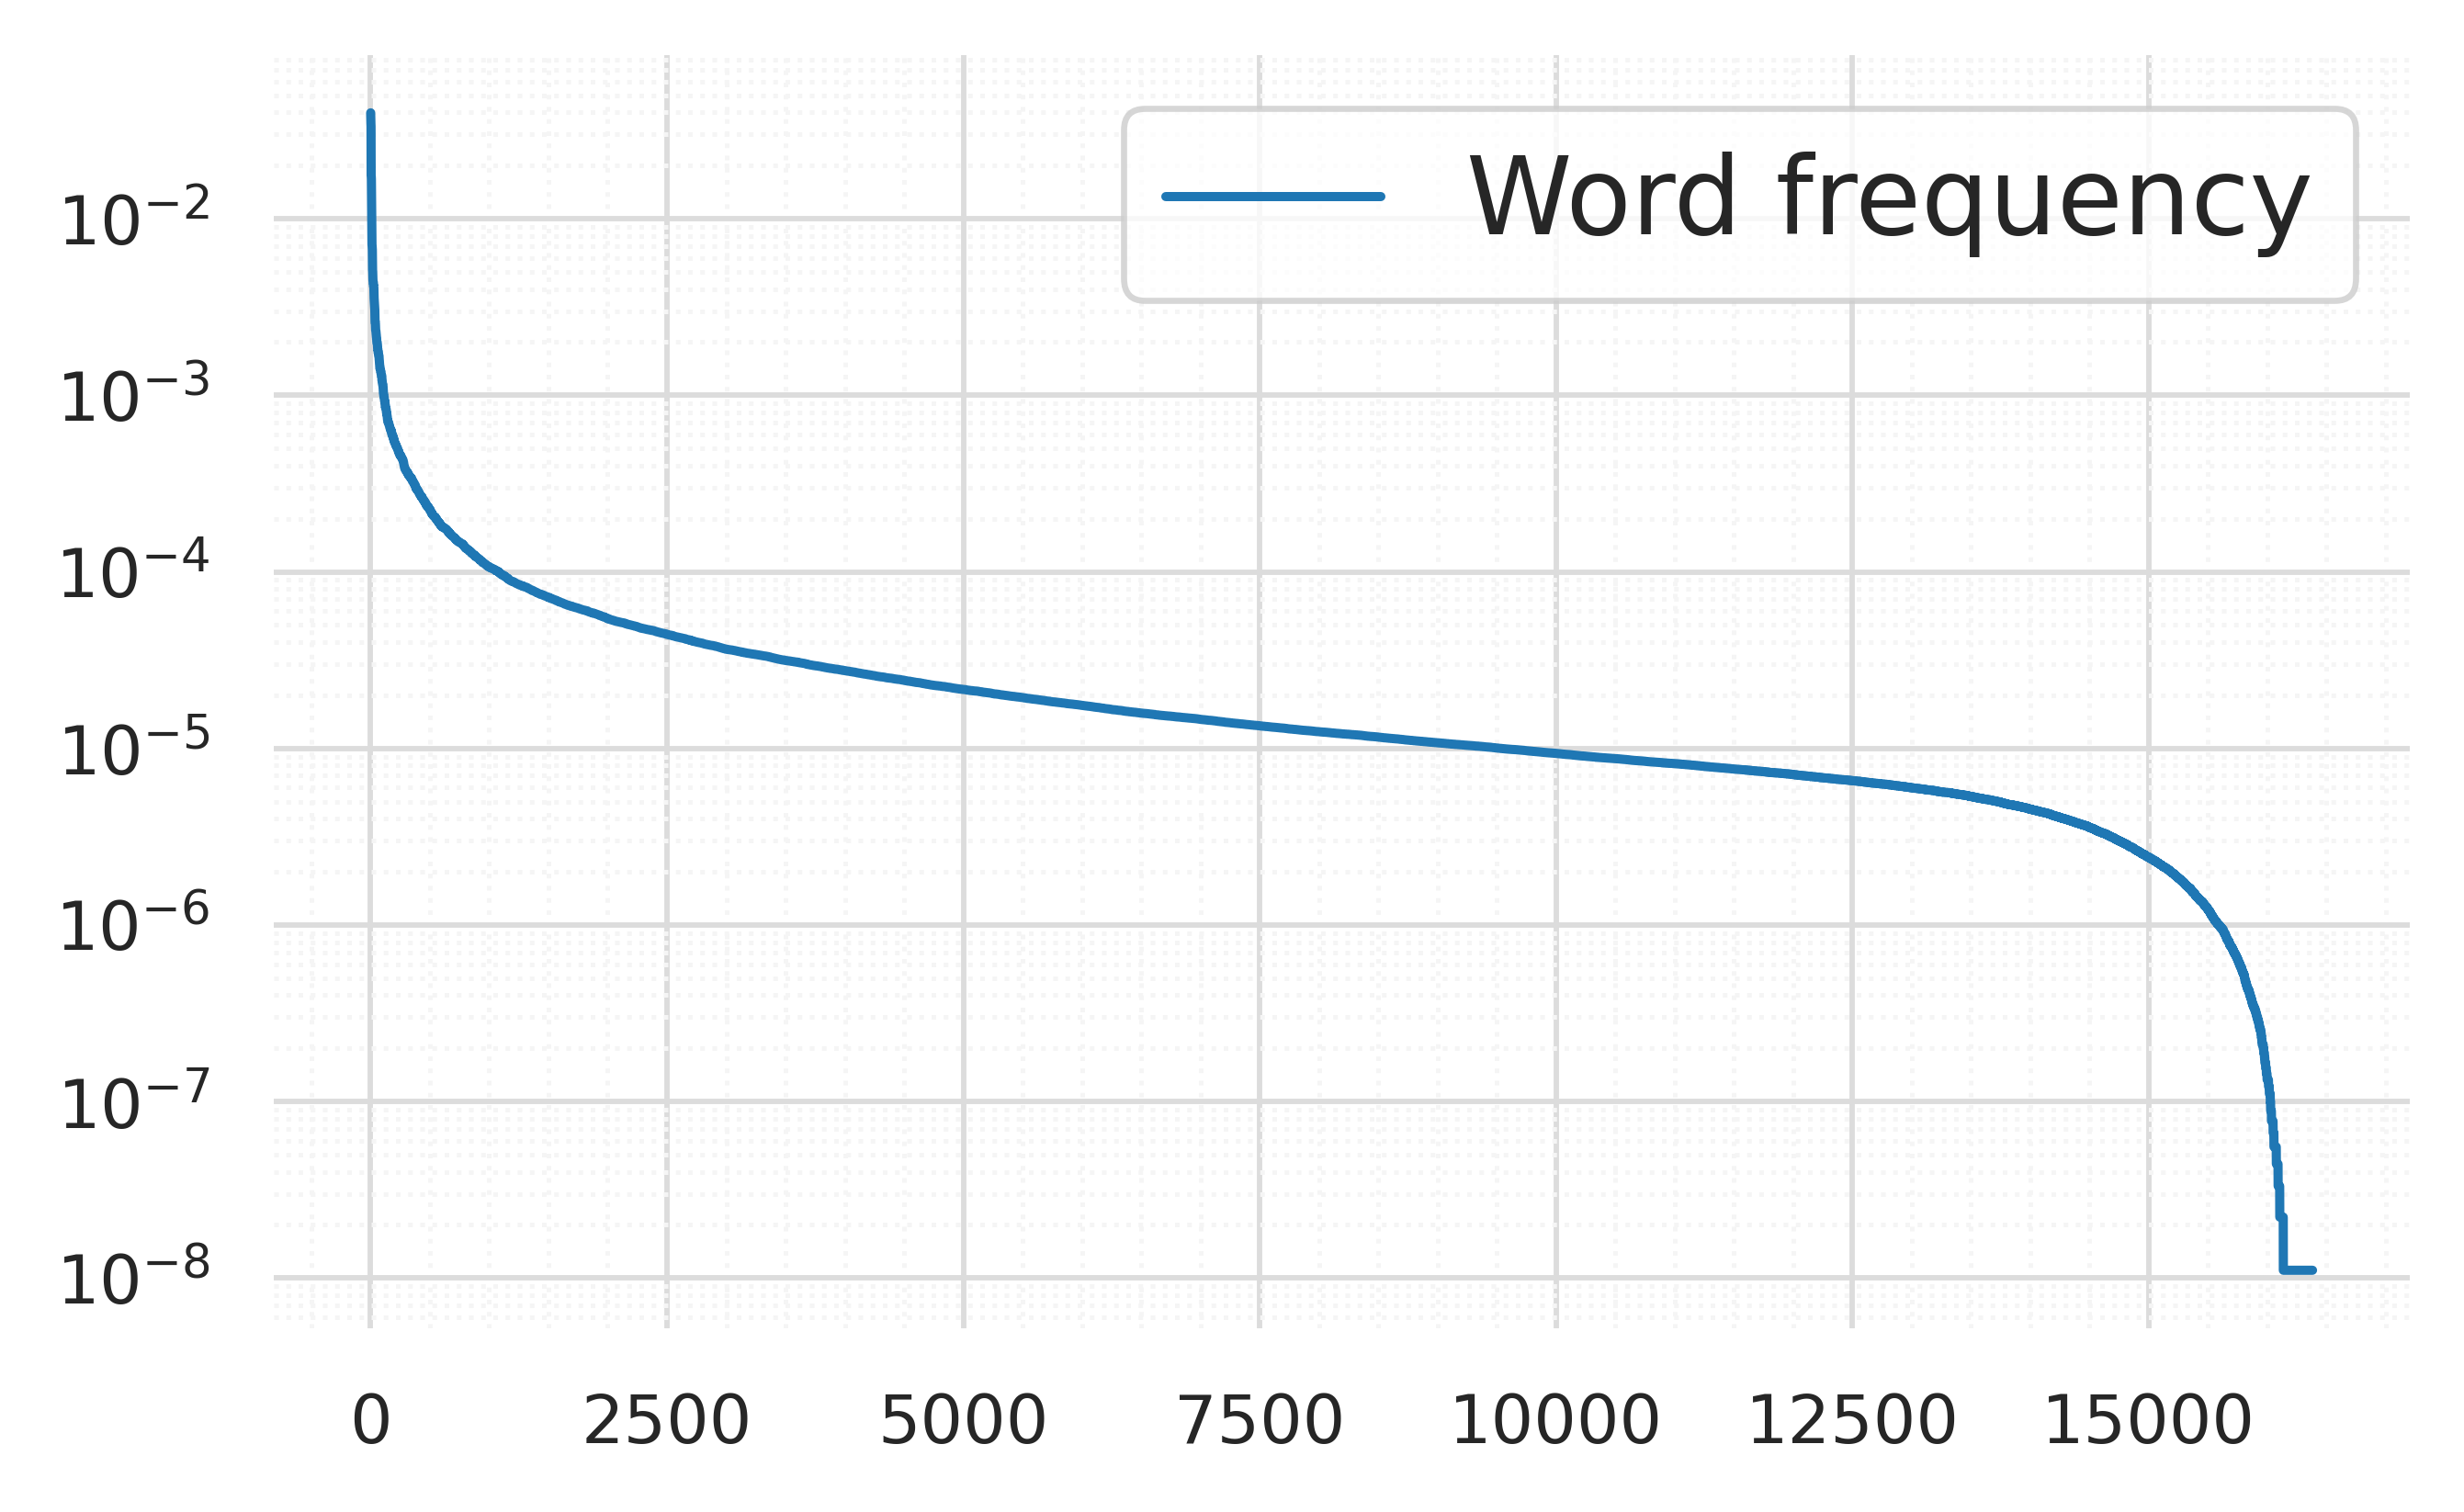

In [34]:
# Show the results for the first time series and its subseries
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(5,3), sharey=True, dpi=600)
    
    plt.plot(np.flip(np.sort(class_frequencies1_norm.numpy())), '-', label='Word frequency', ms=0.5)

    ax.set_yscale('log')
    #ax.set_xscale('symlog',linthresh=10e-2)
    #ax.set_ylim([0.0,1.0])
    #ax.set_xlim([0,1000])

    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.6)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=14)


In [37]:
%ls logs/results

cifar100/        gpt_languini-medium/       gpt_languini_reverseKL-mini2/
cifar10mix/      gpt_languini-mini/         imagenet/
cifar5m/         gpt_languini-mini-medium/  regression/
cifar5m_zero/    gpt_languini-mini-mini/
classification/  gpt_languini-mini2/


In [38]:
path = "./dataset_utils/languini_word_frequency.npy"
np.save(path, class_frequencies.numpy())

In [39]:
cf = np.load(path)

In [41]:
all(cf==class_frequencies.numpy())

True